## Limestone Data Challenge
Swarnim Jain & Tanmay Gejapati

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from xgboost import XGBRegressor
from scipy.optimize import minimize

In [2]:
'''
This code imports necessary libraries and performs data preparation steps such as loading, 
cleaning, and standardizing the data for analysis.
'''

# Load data
stock_prices = pd.read_csv("data_challenge_stock_prices.csv")
index_prices = pd.read_csv("data_challenge_index_prices.csv")

# Calculate returns
stock_returns = stock_prices.pct_change().dropna()
index_returns = index_prices.pct_change().dropna()

# Normalize stock returns
scaler = StandardScaler()
scaled_stock_returns = scaler.fit_transform(stock_returns)

#### Problem Statement - 1

We have used to methods to find the number of clusters for the stocks. One is the gap statistic method and the other is using silhouette scores, along with KMeans in both. The reason for using two methods is to reduce the likelihood of making an error. Both methods gave the same result of M = 4 clusters or 4 sectors. The optimal cluster for the gap statistic method is inferred by the maxima, i.e., peak of the plot. For silhouette scores, we use the elbow method which gives the optimal number of clusters to be the point where the slope of the plot changes abruptly. We did not run this for numbers about 15-25 because the results were evidently getting worse, and according to the nature of the problem, having such a high number was not reasonable, wheras 4 is reasonable for the number of sectors. The plot and code for each method is given below.

C:\Users\swarn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\swarn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\swarn\AppData\Local\Temp/ipykernel_42444/2055480952.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultsdf = resultsdf.append({'cluster_count': k, 'gap': gap}, ignore_index=True)
C:\Users\swarn\AppData\Local\Packages\PythonSoftwareFou

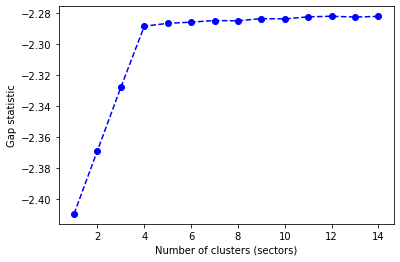

In [3]:
'''
This code defines a function to calculate the optimal number of clusters for KMeans 
clustering using the gap statistic method, and generates a plot of the gap statistic 
curve to visualize the results. The function takes in the standardized financial data as 
input and returns the optimal number of clusters and a DataFrame of the gap statistics 
for different cluster counts. The plot shows the relationship between the number of 
clusters and the gap statistic, with the optimal number of clusters marked by the peak in the curve,
which is seen highest at M = 4.
'''

def gap_statistic(data, nrefs=3, max_clusters=15):
    gaps = np.zeros((len(range(1, max_clusters)),))
    resultsdf = pd.DataFrame({'cluster_count': [], 'gap': []})
    for gap_index, k in enumerate(range(1, max_clusters)):
        ref_disps = np.zeros(nrefs)
        for i in range(nrefs):
            random_data = np.random.random_sample(size=data.T.shape)
            km = KMeans(k, random_state=42)
            km.fit(random_data)
            ref_disp = km.inertia_
            ref_disps[i] = ref_disp
        km = KMeans(k, random_state=42)
        km.fit(data.T)
        orig_disp = km.inertia_
        gap = np.log(np.mean(ref_disps)) - np.log(orig_disp)
        gaps[gap_index] = gap
        resultsdf = resultsdf.append({'cluster_count': k, 'gap': gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)


m, results = gap_statistic(scaled_stock_returns)

# Plot the gap statistic curve
plt.plot(results['cluster_count'], results['gap'], linestyle='--', marker='o', color='b')
plt.xlabel('Number of clusters (sectors)')
plt.ylabel('Gap statistic')
plt.show()

C:\Users\swarn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\swarn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\swarn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\s

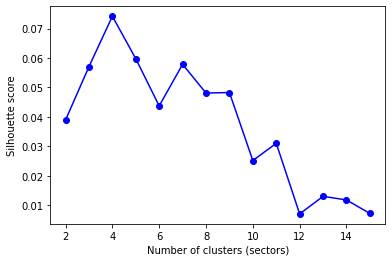

In [5]:
'''
This code calculates the silhouette score for each number of clusters (sectors) using KMeans
clustering and generates a plot of the silhouette score curve to evaluate the clustering quality
by the Elbow method. There is a distince elbow at M = 4, indicating that the optimal number of clusters.
'''

silhouette_scores = []
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_stock_returns.T)
    silhouette_avg = silhouette_score(scaled_stock_returns.T, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette score curve
plt.plot(range(2, 16), silhouette_scores, marker='o', color='b')
plt.xlabel('Number of clusters (sectors)')
plt.ylabel('Silhouette score')
plt.show()

#### Problem Statement - 2

To find the distribution of stocks in each sector (4), we have used the KMeans clustering algorithm as well as spectral clustering. Both give the exact same stock distribution in each sector. The code for both is given below.

In [6]:
M = 4 # optimum number of clusters (stock sectors)

'''
This code performs spectral clustering on the standardized financial data using the 
nearest neighbors method and assigns stocks to different sectors. It then creates a 
dictionary with each sector as a key and a list of stocks belonging to that sector 
as the corresponding value, and prints the list of stocks for each sector.
'''

spectral_clustering = SpectralClustering(n_clusters=M, affinity='nearest_neighbors')
stock_labels = spectral_clustering.fit_predict(scaled_stock_returns.T)

sectors = {i: [] for i in range(M)}
for stock, label in enumerate(stock_labels):
    sectors[label].append(stock)

for sector in sectors:
    print(sectors[sector])

'''
Alternative clustering using KMeans, results are identical to spectral clustering:

# Cluster stocks into sectors
kmeans = KMeans(n_clusters=M).fit(scaled_stock_returns.T)
sectors = kmeans.labels_

# Create a dictionary with sector as key and list of stocks as value
sectors = {i: [] for i in range(M)}
for stock, label in enumerate(stock_labels):
    sectors[label].append(stock)

for sector in sectors:
    print(sectors[sector])
'''

[0, 1, 4, 10, 11, 14, 18, 20, 21, 22, 25, 26, 38, 39, 43, 45, 49, 54, 67, 75, 78, 79, 82, 88, 90]
[5, 13, 15, 24, 31, 34, 35, 37, 48, 56, 61, 62, 64, 65, 68, 70, 76, 83, 85, 86, 89, 93, 94, 95, 97]
[8, 12, 27, 29, 30, 36, 40, 41, 44, 46, 50, 52, 55, 57, 59, 69, 71, 73, 74, 77, 80, 84, 92, 96, 99]
[2, 3, 6, 7, 9, 16, 17, 19, 23, 28, 32, 33, 42, 47, 51, 53, 58, 60, 63, 66, 72, 81, 87, 91, 98]


C:\Users\swarn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


'\nAlternative clustering using KMeans, results are identical to spectral clustering:\n\n# Cluster stocks into sectors\nkmeans = KMeans(n_clusters=M).fit(scaled_stock_returns.T)\nsectors = kmeans.labels_\n\n# Create a dictionary with sector as key and list of stocks as value\nsectors = {i: [] for i in range(M)}\nfor stock, label in enumerate(stock_labels):\n    sectors[label].append(stock)\n\nfor sector in sectors:\n    print(sectors[sector])\n'

#### Problem Statement - 3 & 4

To find the correlation between the individual stocks and each index, we used XGBooster (eXtreme Gradient Boosting) algorithm, a supervised learning ML model. It is also able to account for the Gaussian noise present in $R_{t}^{I_{i}}$ as it can capture complex relationships. We used the returns of the index as the target variable and the returns of the stocks of a sector as the features. We tried running the model for each sector separately and also for all the stocks together. There was practically no difference in the predictive correlations for each sector and for all the stocks together. Each index's predictive correlation with the stock returns is approximately greater than 40% while the average is about 45.6%, hence the assumption that each index is strongly correlated with a single sector seems to hold true. 

The covariance matrix, $\Sigma_{k \times k}$ where $k=15$ (all 15 indices have been solved), is calculated from the predicted returns recieved ftom above method. The predictions, $\mu_{k \times N}$, are also calculated. The code for the model is given below.

In [13]:
'''
This code runs a Gradient Boosting model (supervised learning) on each sector to predict the returns of each 
index. It then calculates the predictive correlation between the predicted returns 
and the actual returns of each index. Each predictive correlation is approximately > 40%.
This model resulted in significantly higher correlations as compared to LinearRegression, 
Ridge, Elastic Net and Lasso models, each of which had similar predictive correlations.

Using all stocks instead of those of a single sector leads to practically identical results,
thus that is a fair assumption to make.
'''

def predict_index_returns(index_returns, stock_returns, sectors):
    predictions = []
    correlations = []
    for i in range(len(index_returns.columns)):
        xgb = XGBRegressor()
        best_corr = 0
        best_pred = None
        for j in range(len(sectors)):
            sector_returns = stock_returns.iloc[:, sectors[j]]
            xgb.fit(sector_returns[:-1], index_returns.iloc[:-1, i])
            pred = xgb.predict(sector_returns)
            corr = np.corrcoef(pred, index_returns.iloc[:, i])[0, 1]
            if corr > best_corr:
                best_corr = corr
                best_pred = pred
        print(f"Index {i}: predictive correlation = {best_corr}")
        correlations.append(best_corr)
        predictions.append(best_pred)
    return correlations, np.array(predictions)

correlations, predictions = predict_index_returns(index_returns, stock_returns, sectors)

cov_matrix = np.cov(predictions)

Index 0: predictive correlation = 0.4579333533660824
Index 1: predictive correlation = 0.3931081910695898


C:\Users\swarn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\swarn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Index 2: predictive correlation = 0.601785494340213
Index 3: predictive correlation = 0.46536130038755935
Index 4: predictive correlation = 0.46107299942362656
Index 5: predictive correlation = 0.5777217657474613
Index 6: predictive correlation = 0.4575896206928276
Index 7: predictive correlation = 0.3882095905333838
Index 8: predictive correlation = 0.3759736690752824
Index 9: predictive correlation = 0.46752678814514514
Index 10: predictive correlation = 0.466392667647596
Index 11: predictive correlation = 0.3863738949625941
Index 12: predictive correlation = 0.3851173003439932
Index 13: predictive correlation = 0.38284529778353965
Index 14: predictive correlation = 0.5879296014024196


In [14]:
print(cov_matrix)

[[ 1.56542326e-08  4.35581214e-10 -1.78341040e-09 -1.51461250e-09
   2.92493995e-09 -3.77143877e-10  2.85124094e-09  2.21302953e-09
   4.33664153e-10 -1.61359272e-09 -8.92153646e-10 -9.97515431e-11
   1.82498549e-11  2.27728382e-11 -3.23953270e-10]
 [ 4.35581214e-10  6.91111685e-10 -4.73801468e-11 -2.53790777e-10
   4.50769007e-10 -3.47675247e-10  5.00062850e-10  6.87682146e-11
   7.72668648e-11 -2.90723298e-10 -9.50569518e-10 -5.64207764e-12
  -2.69671185e-12 -4.05259301e-12 -5.20271927e-11]
 [-1.78341040e-09 -4.73801468e-11  3.16584269e-09  1.38545875e-10
  -3.11544986e-10  4.63306986e-11 -2.43826691e-10 -2.68919780e-10
  -3.66300255e-11  1.58423349e-10  8.38152836e-11  5.46863890e-10
  -6.87433147e-13  1.95145028e-13  2.87258049e-11]
 [-1.51461250e-09 -2.53790777e-10  1.38545875e-10  1.97412451e-08
  -1.15277381e-09  2.12312271e-10 -6.85045165e-09 -2.17657935e-10
  -8.75661949e-10  7.93797984e-10  6.59928910e-10 -7.81767049e-11
  -1.41363749e-11 -1.67183538e-09  1.07519904e-10]
 [ 2

#### Problem Statement - 5

With $\mu$ and $\Sigma$ from the previous part, we used an optimization strategy to find the optimal weights. Our goal of optimization was to maximize the Sharpe ratio, which is the ratio of the expected return to the standard deviation of the return. We used the scipy.optimize.minimize function to minimize the negative of the Sharpe ratio. We wanted to make a risk-free portfolio and hence chose that as the optimization parameter.

In [15]:
def strategy(weights, mu, cov_matrix):
    return -np.dot(weights, mu) / np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

allocations = pd.DataFrame(index=index_returns.index, columns=index_returns.columns)
for t in range(len(index_returns.index) - 7000, len(index_returns.index)):
    mu_t = pd.DataFrame(predictions).T.loc[t]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)}, {'type': 'ineq', 'fun': lambda x: 1 - np.abs(x)})
    result = minimize(strategy, np.ones(15) / 15, args=(mu_t, cov_matrix), constraints=constraints)
    allocations.loc[t] = result.x

strategy_returns = (allocations * index_returns).sum(axis=1)

# Calculate mean, stdev, and Sharpe ratio
mean = strategy_returns.mean()
stdev = strategy_returns.std()
sharpe = mean / stdev

print("Mean:", mean)
print("Stdev:", stdev)
print("Sharpe Ratio:", sharpe)

Mean: 3.794900695330458e-08
Stdev: 3.5819907243014286e-05
Sharpe Ratio: 0.001059439006802719


#### Problem Statement - 6

From the above optimization strategy, we have cacluated the following results:
Mean = 3.79e-8, Stdev = 3.582e-5, Sharpe Ratio = 0.001

Here are the assumptions we made in the above optimization strategy:
1. The covariance matrix is stationary over time
2. No additional constraints on short-selling, unlike in real-world trading
3. No transaction cost for each trade, unlike in real-world trading
4. The optimization problem is solved using a convex optimization solver, assuming that the problem is well-posed and has a unique solution